# Part B Fast price approximator to time dependent derivatives

We used version of **Python 3.9** for this part as we use tensorflow library.

## Pricing Put Down and In with Monte-Carlo

### Introduction

A **Put Down and In** is an option that gives its holder the right, but not the obligation, to sell an underlying asset at a predetermined price only if the price of the underlying asset falls below a specified level during the option's life. <br> <br>
Therefore its **payoff depends on the path of the underlying asset**.<br> <br>
The Monte-Carlo method can be used to price such derivatives but it is computationnaly expensive.

### Pricing

The below algorithm prices put down and in options for various parameters and returns a dataframe with all the prices.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

# We set a seed to have the same results each time, but we may as well do without it to prove that it works no matter the results
np.random.seed(123)


class PutDI:
    def __init__(self, n_years=10, n_scenarios=1000, mu=0,sigma=0.15, steps_per_year=12, s_0=100, strike_price=200,
                 interest_rate=0.05, barrier=80):
        self.n_years = n_years
        self.n_scenarios = n_scenarios
        self.mu = mu
        self.sigma = sigma
        self.steps_per_year = steps_per_year
        self.s_0 = s_0
        self.strike_price = strike_price
        self.dt = 1 / steps_per_year
        self.n_steps = int(n_years * steps_per_year)
        self.interest_rate = interest_rate
        self.barrier = barrier
        
# Evolution of an asset price using a Geometric Brownian Motion
# Generates multiple scenarios of stock prices.
    def gbm(self):
        returns = np.random.normal(loc=(1 + self.mu * self.dt), scale=(self.sigma * np.sqrt(self.dt)),
                                       size=(self.n_steps, self.n_scenarios))
        returns[0] = 1
        prices = self.s_0 * pd.DataFrame(returns).cumprod()
        return prices
# Each column is a scenario and each row the price at a specific time step


# The below function checks if for the different paths simulated if the asset price have reached the barrier

    def payoff_put_down_and_in(self):
        payoff_pdi = []
        gbm = self.gbm()
        barriere_touchee = (gbm <= self.barrier).any()
        for i in range(self.n_scenarios):
            if barriere_touchee[i] and (self.strike_price - gbm.at[self.n_steps - 1, i] >= 0):
                payoff_pdi.append(self.strike_price - gbm.at[self.n_steps - 1, i])
            else:
                payoff_pdi.append(0)
        return pd.DataFrame(payoff_pdi)

    def price_put_di(self):
        payoff_pdi = PutDI.payoff_put_down_and_in(self)
        return float(payoff_pdi.mean().iloc[0] * np.exp(- self.interest_rate * self.n_years))

    
#Calculate the price of the derivative for various parameters
n_years_list = [5, 10, 15]
barrier_list = [70, 80, 90,]
strike_list = [100, 110, 120,130,140]
mu_list = [0.05,0.1]
s_0_list = [90, 100, 110]
sigma_list = [0.15,0.2]
interest_rate_list = [0.02, 0.05]


results = []

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["n_years", "mu", "volatility","interest rate", "barrier","strike","S0","Price"])

# Perform multiple simulations with different parameters
for n_years in n_years_list:
    for barrier in barrier_list:
        for strike in strike_list:
            for s_0 in s_0_list:
                for mu in mu_list:
                    for r in interest_rate_list:
                        for sigma in sigma_list:
                            put = PutDI(n_years=n_years, barrier=barrier, mu = mu, sigma = sigma, interest_rate = r, strike_price = strike, s_0 = s_0)
                
                            price = put.price_put_di()
                
                            df = pd.DataFrame({"n_years": [n_years],"mu":[mu], "volatility":[sigma],"interest rate": [r], "barrier": [barrier], "strike": [strike], "S0":[s_0] , "Price": [price]})
                            results.append(df)
            
results_df = pd.concat(results, ignore_index=True)

# Display the results
print(results_df)

      n_years    mu  volatility  interest rate  barrier  strike   S0  \
0           5  0.05        0.15           0.02       70     100   90   
1           5  0.05        0.20           0.02       70     100   90   
2           5  0.05        0.15           0.05       70     100   90   
3           5  0.05        0.20           0.05       70     100   90   
4           5  0.10        0.15           0.02       70     100   90   
...       ...   ...         ...            ...      ...     ...  ...   
1075       15  0.05        0.20           0.05       90     140  110   
1076       15  0.10        0.15           0.02       90     140  110   
1077       15  0.10        0.20           0.02       90     140  110   
1078       15  0.10        0.15           0.05       90     140  110   
1079       15  0.10        0.20           0.05       90     140  110   

          Price  
0      4.794629  
1     10.535996  
2      4.105728  
3      8.149764  
4      1.537230  
...         ...  
1075   9.

In [11]:
# Display all the lines to compare the prices
print(results_df.to_string(index=False))

 n_years   mu  volatility  interest rate  barrier  strike  S0     Price
       5 0.05        0.15           0.02       70     100  90  4.794629
       5 0.05        0.20           0.02       70     100  90 10.535996
       5 0.05        0.15           0.05       70     100  90  4.105728
       5 0.05        0.20           0.05       70     100  90  8.149764
       5 0.10        0.15           0.02       70     100  90  1.537230
       5 0.10        0.20           0.02       70     100  90  4.393211
       5 0.10        0.15           0.05       70     100  90  1.172887
       5 0.10        0.20           0.05       70     100  90  3.733260
       5 0.05        0.15           0.02       70     100 100  3.256618
       5 0.05        0.20           0.02       70     100 100  7.031666
       5 0.05        0.15           0.05       70     100 100  2.391080
       5 0.05        0.20           0.05       70     100 100  6.056009
       5 0.10        0.15           0.02       70     100 100  0

**Remark**: The prices make quite a long time to load with the Monte-Carlo method.

## Neural network creation and training

### Creation

Input dimension = 7 <br>
>- Layer 1: <br>
 type: Dense <br>
 width: 64 <br>
 activation: Sigmoid <br>
 initialization: glorot_uniform
 
 >- Layer 2:<br>
 type: Dense<br>
 width: 128<br>
 activation: Relu <br>
 initialization: he_uniform
 
 Output dimension: 1<br>
 Output activation: linear<br>
 
 Optimizer: Adam<br>
 Learning rate: 0.03

In [2]:
#Librairies and data preparation

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


X = results_df[["n_years", "mu","volatility", "interest rate", "barrier", "strike", "S0"]].values
y = results_df[["Price"]].values

# Standardize
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the data: 70% training set, 15% validation set and 15% testing set
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.3, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12)

### Training

In [3]:
# Model Specification

model = keras.Sequential([
    keras.layers.Input(shape=(7,)),  # Input layer
    keras.layers.Dense(64, activation='sigmoid',  kernel_initializer='glorot_uniform'),  # Hidden layer
    keras.layers.Dense(128, activation='relu', kernel_initializer = 'he_uniform'),  # Hidden layer
    keras.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform')  # Output layer with linear activation
])

# Compilation and training

model.compile(optimizer=Adam(learning_rate=0.03), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val,y_val),verbose = 1)

model.save('PDI')

Epoch 1/200
24/24 [==============================] - 1s 17ms/step - loss: 16.8788 - val_loss: 4.6505
Epoch 2/200
24/24 [==============================] - 0s 5ms/step - loss: 3.9656 - val_loss: 2.3105
Epoch 3/200
24/24 [==============================] - 0s 5ms/step - loss: 2.6675 - val_loss: 1.9482
Epoch 4/200
24/24 [==============================] - 0s 5ms/step - loss: 2.2360 - val_loss: 1.6355
Epoch 5/200
24/24 [==============================] - 0s 5ms/step - loss: 1.9957 - val_loss: 1.2311
Epoch 6/200
24/24 [==============================] - 0s 5ms/step - loss: 1.8668 - val_loss: 1.0506
Epoch 7/200
24/24 [==============================] - 0s 5ms/step - loss: 1.7268 - val_loss: 1.6272
Epoch 8/200
24/24 [==============================] - 0s 5ms/step - loss: 1.3735 - val_loss: 0.8945
Epoch 9/200
24/24 [==============================] - 0s 5ms/step - loss: 1.2602 - val_loss: 0.9575
Epoch 10/200
24/24 [==============================] - 0s 5ms/step - loss: 1.1757 - val_loss: 1.6427
Epoch 1

We have adjusted the hyperparameters in order to have a low final loss value.

The loss value decreasing with epochs, mean that the model is learning and improving. <br>
A low loss value indicates that the model is **fitting the training data well**.<br><br>
However, we need to **check the validation loss** set to see if the model fits well unseen data, if there is no overfitting.

## Validation of Neural Network performance

The validation loss indicates the mean squared error between the model's predictions and the actual target values for the set. <br>

If we have a high loss validation, it means there is overfitting and therefore we have to change the hyperparameters again.

We plot the training and validation losses over the epochs to compare them visually.

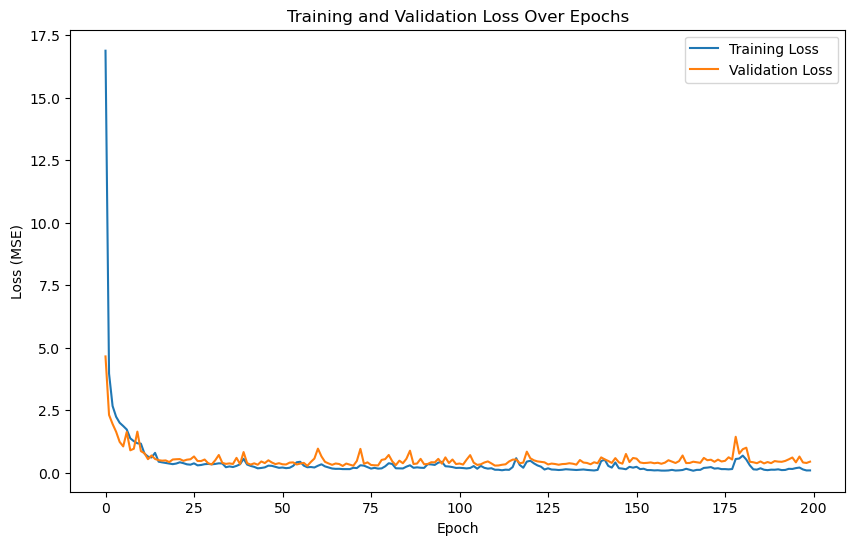

In [4]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')

plt.show()

The validation loss seen on the previous part is low and close to the training loss, the graph confirms it. Therefore the **model is performing well on the validation set**.

## Testing the Neural Network

With the trained model, we make **predictions on the test set** and compare these predictions to true values.

In [5]:
from sklearn.metrics import mean_squared_error

# Use the trained model to make predictions on the test set
predictions = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) between predictions and actual values assuming y_test is the actual target values
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error on the test set:", mse)

6/6 [==============================] - 0s 3ms/step
Mean Squared Error on the test set: 0.3260285851472445


We see that the mean squared error is very low, therefore the **model's performance is good**.

We can plot the result of predictions vs reality on the testing set. It is almost a line.

6/6 [==============================] - 0s 3ms/step


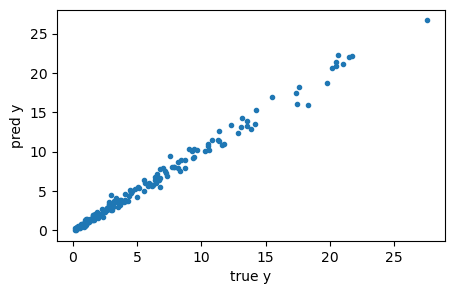

In [6]:
y_pred = model.predict(X_test)

plt.figure(figsize = (5,3))
plt.plot(y_test, y_pred,'.')
plt.xlabel('true y')
plt.ylabel('pred y')
plt.show()

And on the training set:

24/24 [==============================] - 0s 3ms/step


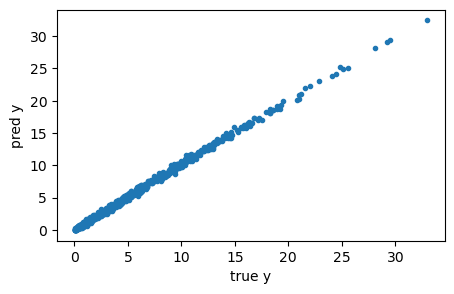

In [7]:
y_pred2 = model.predict(X_train)

plt.figure(figsize = (5,3))
plt.plot(y_train, y_pred2,'.')
plt.xlabel('true y')
plt.ylabel('pred y')
plt.show()

#### Accuracy

When looking at the results from the three steps: training, validation and testing, we see that the model fits well at every step and with unseen data. Therefore **the model is accurate** to predict prices of Put Down and In when being given initial parameters.

## Measure the speed of the approximator

In [8]:
import time

# Predictions on the training set, it is the longest
start_time = time.time()
predictions = model.predict(X_train)
end_time = time.time()

# We calculate the time taken in seconds for predictions
elapsed_time = end_time - start_time

print("Time taken for predictions: ",elapsed_time," seconds")

24/24 [==============================] - 0s 3ms/step
Time taken for predictions:  0.19443130493164062  seconds


**The model is very fast** to predict the prices of Put Down and In compared to the Monte Carlo algorithm implemented at the beginning which is quite long to load. 

## Comparison

Monte-Carlo methods are known for their accuracy but also for being computationnally expensive and slow. However Neural Network methods' accuracy can vary depending on the quality and quantity of training data, on hyperparameters chosen... If the model is well calibrated, it is also accurate. These programs are also faster.